# VAE sample generation

In [1]:
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
from typing import Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import os

eight_by_five = pd.read_csv(
    '/Users/karlberb/work/sample_count/smpl_gen/architechture/X_intersect_5k_mad_feats_cohorts_n25.tsv',
    sep = '\t', index_col = 0)

def normalize(data: pd.DataFrame, features: list, feature_range: Tuple = None, scaler=None) -> (pd.DataFrame, any):
        if feature_range is not None and scaler is None:
            scaler = MinMaxScaler(feature_range=feature_range)
            scaler.fit(data)
        elif feature_range is None and scaler is None:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler.fit(data)

        data = scaler.transform(data)

        return pd.DataFrame(columns=features, data=data), scaler
    
def create_splits(input_data: pd.DataFrame, without_val: bool = False) -> Tuple:
        """
        Creates train val test split of the data provided
        @param input_data: The input data which should be split
        @param without_val: If true only a test and a train set will be created
        @return: A tuple containing all the sets.
        """

        # No validation set will be created
        if without_val:
            return train_test_split(input_data, test_size=0.2, random_state=1, shuffle=True)

        # Create validation set
        X_dev, X_val = train_test_split(input_data, test_size=0.05, random_state=1, shuffle=True)
        X_train, X_test = train_test_split(X_dev, test_size=0.25, random_state=1, shuffle=True)
        return X_train, X_val, X_test
    
class Sampling(layers.Layer): # inheriting
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs): # probably a tuple
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs): # **kwargs ?
        super(VAE, self).__init__(**kwargs)
        
        self.encoder: Model = encoder
        self.decoder: Model = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property # wrap methods as variable, for interactive, has getter (no setter)
                # add example as needed (syntantic sugar) further abstraction
                #
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape: # syntactic sugar, create a temporary instance to save memory (?)
                                        # dispose of when out scope
                                        # Replace with human interpretable version, try, properly closed
                                        # finally statement, deal with error
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)
    
latent_dim = 20 # Latent dims
data_path = "/Users/karlberb/work/sample_count/smpl_gen/architechture/X_intersect_5k_mad_feats_cohorts_n25.tsv"
# Path to the data
epochs = 15 # The number of epochs
batch_size = 128 # The batch size
base_path = "decoded_BRCA" # The base path where results are being stored
prefix = "sample_gen" # The prefix used for result files

data = pd.read_csv(data_path, sep='\t', index_col=0)
data = np.trunc(1000 * data) / 1000

train_data, val_data, test_data = create_splits(input_data=data, without_val=False)

train_data, scaler = normalize(train_data, features=train_data.columns)
val_data, _ = normalize(val_data, features=val_data.columns, scaler=scaler)
test_data, _ = normalize(data=test_data, features=test_data.columns, scaler=scaler)



NameError: name 'data' is not defined

In [4]:
latent_dim = 20 # Latent dims

In [5]:
latent_dim

20

In [6]:
tpl_3lyr = (500, 250, 50)

In [ ]:
tpl_4lyr = (1000, 500, 250, 50)

In [20]:
type(eight_by_five.iloc[0,0])

numpy.float64

In [21]:
eight_by_five

,N:GEXP::COL1A1:1277:,N:GEXP::ALB:213:,N:GEXP::FN1:2335:,N:GEXP::GAPDH:2597:,N:GEXP::ACTB:60:,N:GEXP::KRT5:3852:,N:GEXP::FTL:2512:,N:GEXP::EEF1A1:1915:,N:GEXP::B2M:567:,N:GEXP::COL3A1:1281:,...,N:GEXP::SMURF1:57154:,N:GEXP::GNPNAT1:64841:,N:GEXP::DMXL1:1657:,N:GEXP::AKT3:10000:,N:GEXP::ProSAPiP1:9762:,N:GEXP::RANBP3:8498:,N:GEXP::SIDT2:51092:,N:GEXP::AS3MT:57412:,N:GEXP::ALOX5:240:,N:GEXP::PHF2:5253:
TCGA-OR-A5J1,485.59,1.4409,1558.60,57986.0,68807.0,0.0000,13570.0,33046.0,18943.0,325.65,...,2448.60,383.77,640.73,853.03,243.04,3165.2,1013.50,133.53,90.7780,1230.10
TCGA-OR-A5J2,4269.10,5.2342,20086.00,45123.0,71065.0,0.8053,59215.0,61616.0,17621.0,13904.00,...,1632.40,525.03,801.24,678.84,501.27,1733.7,937.23,1985.00,26.5740,1115.70
TCGA-OR-A5J3,1164.90,5.3325,7744.60,271000.0,73505.0,1.1850,56320.0,77490.0,29841.0,1450.50,...,1785.50,674.86,1148.30,250.04,267.22,3143.2,1407.90,16851.00,20.1450,798.70
TCGA-OR-A5J5,1531.40,312.9400,17322.00,127710.0,111060.0,0.0000,40738.0,40610.0,6510.5,749.03,...,1209.10,254.07,1507.40,469.40,307.51,5023.2,617.51,26278.00,61.1930,2089.10
TCGA-OR-A5J6,376.11,1.1177,787.43,45653.0,52458.0,0.0000,166900.0,79786.0,39353.0,415.23,...,805.25,245.90,810.34,357.67,829.90,2113.6,2382.70,15389.00,156.4800,452.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WC-AA9E,76.65,0.8861,403.63,56811.0,69981.0,30.5720,37423.0,98720.0,16375.0,922.02,...,1122.70,1078.40,621.62,636.24,587.50,1790.4,2318.20,381.48,4.4307,1086.00
TCGA-YZ-A980,1841.30,0.8220,2852.40,103200.0,44996.0,1.2330,48825.0,101630.0,29023.0,1208.40,...,815.75,254.42,886.97,958.90,3026.30,2503.9,993.33,248.25,71.9280,1382.70
TCGA-YZ-A982,144.25,0.0000,628.32,59826.0,82306.0,7.0796,73261.0,64212.0,7694.7,152.21,...,924.24,233.63,142.48,859.29,734.51,2144.2,1912.80,363.70,23.0090,1319.50
TCGA-YZ-A983,490.15,0.6158,774.01,83361.0,37870.0,53.5710,32539.0,348050.0,10348.0,592.98,...,1221.20,489.53,900.25,364.53,742.61,1456.9,1181.20,100.98,21.5520,942.73


In [7]:
input_dimensions = train_data.shape[1]

# features count in first
encoder_inputs = keras.Input(shape=(input_dimensions,)) # <--- Please explain

x = layers.Dense(units=500, activation="relu")(encoder_inputs)
x = layers.Dense(units=250, activation="relu")(x)
x = layers.Dense(units=50, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # Sampling
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(units=50, activation="relu")(latent_inputs)
x = layers.Dense(units=250, activation="relu")(x)
x = layers.Dense(units=500, activation="relu")(latent_inputs)

decoder_outputs = layers.Dense(units=input_dimensions, activation="relu")(x) # 

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae: VAE = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # Compile

# vae.summary()

callbacks = []

early_stop = EarlyStopping(monitor="reconstruction_loss",
                           mode="min", patience=5,
                           restore_best_weights=True)
callbacks.append(early_stop)

csv_logger = CSVLogger(os.path.join(base_path, 'training.log'),
                       separator='\t')
callbacks.append(csv_logger)

history = vae.fit(train_data,
                  callbacks=callbacks,
                  validation_data=(val_data, val_data),
                  epochs=epochs, batch_size=batch_size)

2022-10-02 11:50:24.950294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          2500500     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          125250      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           12550       dense_1[0][0]                    
____________________________________________________________________________________________

2022-10-02 11:50:25.618483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
45/45 [==============================] - 3s 39ms/step - loss: 9.7153 - reconstruction_loss: 0.7028 - kl_loss: 2.8178 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/15
45/45 [==============================] - 1s 32ms/step - loss: 0.6992 - reconstruction_loss: 0.6986 - kl_loss: 5.2757e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/15
45/45 [==============================] - 2s 38ms/step - loss: 0.6989 - reconstruction_loss: 0.6986 - kl_loss: 3.7671e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/15
45/45 [==============================] - 1s 33ms/step - loss: 0.6988 - reconstruction_loss: 0.6986 - kl_loss: 2.5485e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/15
45/45 [==============================] - 2s 34ms/step - loss: 0.6986 - reconstruction_loss: 0

In [17]:
import matplotlib.pyplot as plt

KeyError: 'val_loss'

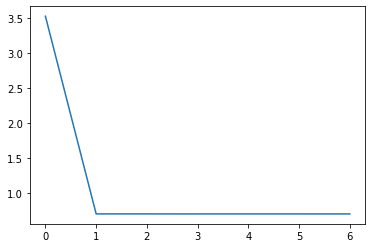

In [18]:
# plot summary
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
z_mean, z_var, embedding = vae.encoder.predict(test_data)
embedding = pd.DataFrame(embedding)

In [13]:
embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.131048,0.270246,-0.246083,0.041365,-0.163836,0.081337,1.413786,1.199056,-0.027455,-1.752282,0.961755,0.647381,-0.444597,-0.325811,1.549471,1.184693,0.797333,-1.082510,0.530332,-1.198620
1,-0.126688,-0.865537,0.011768,1.666962,-0.858121,0.031922,2.324522,0.294791,1.555727,0.223849,2.093488,0.902878,1.418053,0.336374,2.166124,-0.232539,-0.566460,0.805488,0.984941,0.720381
2,2.309409,0.240684,-0.578722,0.997785,1.820078,0.279088,0.615279,-0.819495,1.053660,-1.551843,0.691233,1.401377,-0.907378,-0.511405,1.238655,-0.338208,-0.062315,1.002610,1.392565,-0.336053
3,-0.287645,0.065249,-2.163270,1.530519,-0.288061,0.780958,-0.141689,0.358015,-1.322854,-1.490353,-0.037181,0.115612,1.126498,0.561229,0.050845,-1.157329,0.498627,-0.756968,-0.585653,-1.147182
4,1.190632,0.247284,-0.053285,-0.289804,0.387546,-0.203408,-1.908330,0.791477,-0.683180,-0.441528,1.280293,-0.496062,0.952481,-1.316954,-0.711487,1.530819,1.659239,0.212300,1.216703,-0.481534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,0.330639,1.742745,-0.808699,0.347513,-0.114090,-0.558794,-0.088584,-0.353778,0.601817,0.134081,0.234888,0.350498,1.679500,0.845552,0.645152,-1.467395,-0.836085,-1.557396,0.140161,1.063640
1898,-0.476100,-0.022002,-1.233572,-0.522810,0.608137,-0.129818,-0.744741,0.092841,0.943900,0.928072,-1.096905,-0.207279,0.263436,0.214837,0.746481,0.078662,-0.723470,-0.957757,-0.636214,0.076773
1899,0.166873,1.765147,-0.369428,1.228784,-0.222983,-1.079029,-0.875732,-1.523083,3.151026,-0.732707,-0.374783,-1.496104,-0.116037,-0.398805,-0.199335,-0.473715,0.119911,-0.120860,-0.057998,-1.437070
1900,0.082826,-2.396239,0.053919,-0.828997,0.771006,-1.277385,0.633936,-0.780836,-2.320095,-1.102198,0.414342,0.845820,1.074169,0.152199,0.418365,-1.439395,-0.249705,-1.376707,-0.375378,-0.434578


In [9]:
base_path

'decoded_BRCA'

In [8]:
5000*500

2500000

In [ ]:
# Archive

In [13]:
input_dimensions = train_data.shape[1]

# features count in first
encoder_inputs = keras.Input(shape=(input_dimensions,)) # <--- Please explain

x = layers.Dense(units=1000, activation="relu")(encoder_inputs)
x = layers.Dense(units=500, activation="relu")(x)
x = layers.Dense(units=100, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) # Sampling
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(units=100, activation="relu")(latent_inputs)
# x = layers.Dense(units=500, activation="relu")(x)
x = layers.Dense(units=1000, activation="relu")(latent_inputs)

decoder_outputs = layers.Dense(units=input_dimensions, activation="relu")(x) # 

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae: VAE = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# vae.summary()

callbacks = []

early_stop = EarlyStopping(monitor="reconstruction_loss",
                           mode="min", patience=5,
                           restore_best_weights=True)
callbacks.append(early_stop)

csv_logger = CSVLogger(os.path.join(base_path, 'training.log'),
                       separator='\t')
callbacks.append(csv_logger)

history = vae.fit(train_data,
                  callbacks=callbacks,
                  validation_data=(val_data, val_data),
                  epochs=epochs, batch_size=batch_size)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1000)         5001000     input_5[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 500)          500500      dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          50100       dense_11[0][0]                   
____________________________________________________________________________________________

2022-09-30 14:25:45.262843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
45/45 [==============================] - 8s 146ms/step - loss: 21.2220 - reconstruction_loss: 0.7071 - kl_loss: 6.1285 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/15
45/45 [==============================] - 6s 134ms/step - loss: 0.7052 - reconstruction_loss: 0.6986 - kl_loss: 0.0054 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/15
45/45 [==============================] - 6s 133ms/step - loss: 0.7010 - reconstruction_loss: 0.6986 - kl_loss: 0.0019 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/15
45/45 [==============================] - 6s 141ms/step - loss: 0.6993 - reconstruction_loss: 0.6986 - kl_loss: 6.2198e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/15
45/45 [==============================] - 6s 135ms/step - loss: 0.6987 - reconstruction_loss: 0.6

In [14]:
z_mean, z_var, embedding = vae.encoder.predict(train_data)

In [15]:
embedding

array([[ 1.1393836 ,  0.37125504, -0.9112674 , ...,  0.6503524 ,
        -0.8516645 ,  1.1269784 ],
       [ 1.8653744 , -0.6948046 , -0.50953454, ...,  0.6189342 ,
        -1.5743269 , -0.26229087],
       [ 0.45815405,  1.0232786 , -1.3403239 , ..., -0.7619574 ,
        -1.8295772 , -2.6909783 ],
       ...,
       [ 0.87550706, -1.2188705 ,  0.7291777 , ..., -0.962931  ,
         2.661737  ,  1.3980938 ],
       [ 1.6765723 , -0.27009642, -1.3959305 , ..., -0.06532443,
         1.9460304 ,  0.46898675],
       [-0.7611093 ,  0.04697263,  0.5281616 , ...,  1.5470366 ,
         0.9485749 ,  0.2517841 ]], dtype=float32)

In [16]:
decoder.predict(embedding)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
vae: VAE = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [27]:
epochs = 15 # The number of epochs

In [ ]:
history = vae.fit(train_data,
                  callbacks=callbacks,
                  validation_data=(val_data, val_data),
                  epochs=epochs, batch_size=batch_size)

In [28]:
history = vae.fit(train_data,
                  callbacks=callbacks,
                  validation_data=(val_data, val_data),
                  epochs=epochs, batch_size=batch_size)

Epoch 1/15
45/45 [==============================] - 22s 471ms/step - loss: 0.6995 - reconstruction_loss: 0.6986 - kl_loss: 2.2449e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/15
45/45 [==============================] - 20s 455ms/step - loss: 0.6985 - reconstruction_loss: 0.6987 - kl_loss: 8.4374e-07 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/15
45/45 [==============================] - 21s 465ms/step - loss: 0.6986 - reconstruction_loss: 0.6986 - kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/15
45/45 [==============================] - 21s 459ms/step - loss: 0.6986 - reconstruction_loss: 0.6986 - kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/15
45/45 [==============================] - 21s 464ms/step - loss: 0.6986 - reconstr

### Create embeddings for test data

In [39]:
z_mean, z_var, embedding = vae.encoder.predict(test_data)

In [40]:
embedding

array([[ 1.9870646 ,  1.0416583 , -0.7838087 , ..., -0.53242105,
        -0.7526022 , -0.39004812],
       [ 0.34480008, -1.2102859 ,  0.516639  , ..., -0.17086384,
        -0.87621814, -0.41115296],
       [ 0.9989898 , -1.5573266 ,  1.3649637 , ..., -1.0215573 ,
        -0.10033275,  1.0939907 ],
       ...,
       [-1.1655518 , -0.5408735 ,  0.41010308, ...,  0.9028942 ,
         1.2008036 ,  1.0852925 ],
       [ 2.0437467 ,  1.3344986 ,  0.0473986 , ..., -1.1208513 ,
         0.86585915,  1.5747652 ],
       [-0.9168553 , -1.058427  ,  0.9859297 , ..., -0.4353223 ,
         1.3822342 , -0.11381175]], dtype=float32)

In [41]:
decoder.predict(embedding)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
z_mean, z_var, embedding = vae.encoder.predict(test_data)
embedding = pd.DataFrame(embedding)
embedding.to_csv(Path(base_path, f"{prefix}_embeddings.csv"), index=False)